In [2]:
# import a few packages/libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler

In [4]:
# read in datasets
red = pd.read_csv("../datasets/winequality-red.csv", sep=';')
white = pd.read_csv("../datasets/winequality-white.csv", sep=';')

# extract qualities (target values)
red_quality = red['quality']
white_quality = white['quality']

# remake datasets with normalized values and no quality feature
scaler = StandardScaler()
red = pd.DataFrame(scaler.fit_transform(red.drop(columns=['quality'])), columns=red.columns[:-1])
white = pd.DataFrame(scaler.fit_transform(white.drop(columns=['quality'])), columns=white.columns[:-1])

In [5]:
# split into training and testing sets
red_train, red_test = train_test_split(red, test_size=0.15)
white_train, white_test = train_test_split(white, test_size=0.15)

# get the qualities for each set
red_train_y = red_quality[red_train.index]
red_test_y = red_quality[red_test.index]
white_train_y = white_quality[white_train.index]
white_test_y = white_quality[white_test.index]

In [6]:
# define neuron with Pytorch
class Neuron (nn.Module):
    def __init__(self):
        super(Neuron, self).__init__()
        self.layer = nn.Linear(11, 1)

    def forward(self, x):
        return self.layer(x)

In [7]:
# define a function to train a linear regression model
# X = feature data
# y = target vector
# rp = regularization parameter
# lr = learning rate
# epochs = number of iterations
def trainModel(X, y, rp, lr, epochs):
    
    # create neuron object and set it in training mode
    n = Neuron()
    n.train()
    
    # use Mean Squared Error as loss function
    loss_func = nn.MSELoss()
    
    # use SGD (with weight decay and the regularization parameter) as optimizer function
    optimizer = optim.SGD(n.parameters(), lr=lr, weight_decay=rp)
    
    # create pytorch tensors from data
    xs = torch.tensor(X.values, dtype=torch.float32)
    ys = torch.tensor(y.values.reshape(-1, 1), dtype=torch.float32)

    # train model
    for epoch in range(epochs):

        # compute current predictions of y
        predictions = n(xs)

        # compute loss (MSE)
        loss = loss_func(predictions, ys)

        # zero gradients and compute new gradients
        optimizer.zero_grad()
        loss.backward()

        # update weights
        optimizer.step()

        # if epoch % 1000 == 0:
            # print(f"Training Loss: {loss.item():.4f}")

    n.eval()
    return n

In [8]:
# define function to get a 1-D numpy array of predictions from given model on given data
def test(model, data):
    with torch.no_grad():
        return model(torch.tensor(data.values, dtype=torch.float32)).flatten().numpy()

# define a quick MSE function for just calculating testing loss
def mse(y1, y2):
    return np.mean((y1 - y2) ** 2)

In [9]:
# define function to print out graph showing different values for 
def plotLambdas(trainX, trainY, testX, testY):

    # variables
    epochs = 2500
    learning_rate = 0.005

    # for saving testing and training loss
    trainLoss = []
    testLoss = []

    # define range of regularization parameters to try
    reg_params = [0.00001, 0.0001, 0.001, 0.01, 0.1]

    # loop through different regularization parameters
    for l in reg_params:

        # train model on just training data
        model = trainModel(trainX, trainY, l, learning_rate, epochs)

        # get training and testing loss and append to respective lists
        trainLoss.append(mse(test(model, trainX), trainY.values.reshape(-1, 1)))
        testLoss.append(mse(test(model, testX), testY.values.reshape(-1, 1)))

    # plot training and testing error against regularization parameter (help from ChatGPT)
    plt.plot(reg_params, trainLoss, label='Training Error')
    plt.plot(reg_params, testLoss, label='Testing Error')
    plt.xlabel('Lambda')
    plt.xscale('log')
    plt.xticks(ticks=reg_params, labels=reg_params)
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.show()

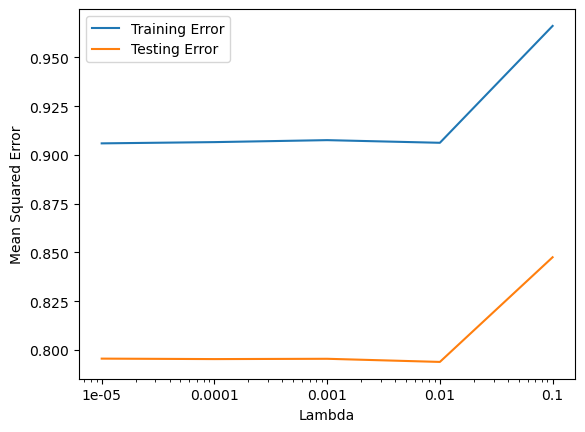

In [10]:
# plot logarithmic graph of regularization parameters vs error for red wine
plotLambdas(red_train, red_train_y, red_test, red_test_y)

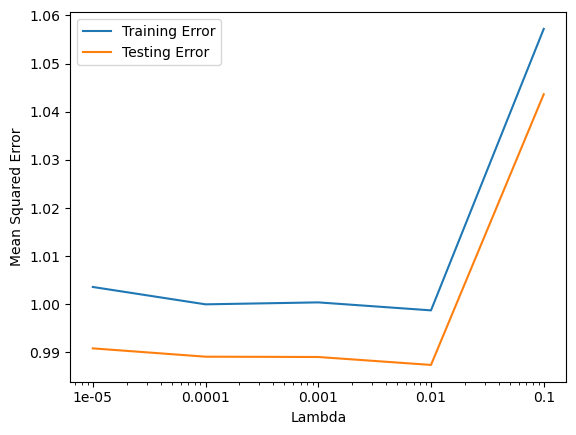

In [11]:
# plot logarithmic graph of regularization parameters vs error for white wine
plotLambdas(white_train, white_train_y, white_test, white_test_y)

### Based on the graphs, it appears that a regularization parameter of 0.01 is a sweet spot for both the red and white wine datasets, so I will stick with that for the first part.

In [12]:
# cross validation using 'K-Fold Cross Validation'
def plotCrossValidationLambdas(data, targets):

    # variables
    epochs = 2500
    learning_rate = 0.005

    # for saving testing loss
    testLoss = []

    # define range of regularization parameters to try
    reg_params = [0.00001, 0.0001, 0.001, 0.01, 0.1]
    
    # create shuffler
    shuffler = ShuffleSplit()

    # for saving the best model
    best = None
    best_err = -1

    # loop through all regularization parameters
    for l in reg_params:

        # keep track of average loss
        test_avg = 0

        # loop through K folds
        for train_index, test_index in shuffler.split(data):

            # splice arrays to get training and testing data
            trainX = data.iloc[train_index]
            trainY = targets.iloc[train_index]
            testX = data.iloc[test_index]
            testY = targets.iloc[test_index]

            # train model on just training data
            model = trainModel(trainX, trainY, l, learning_rate, epochs)
    
            # get testing loss and add to running average
            test_err = mse(test(model, testX), testY.values.reshape(-1, 1))
            test_avg += test_err

            # update best model
            if best == None or test_err < best_err:
                best = model

        # compute training and testing error averages and append to respective lists
        testLoss.append(test_avg/10)

    # plot testing error against regularization parameter (help from ChatGPT)
    plt.plot(reg_params, testLoss, label='Testing Error')
    plt.xlabel('Lambda')
    plt.xscale('log')
    plt.xticks(ticks=reg_params, labels=reg_params)
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.show()

    # return best model
    return best

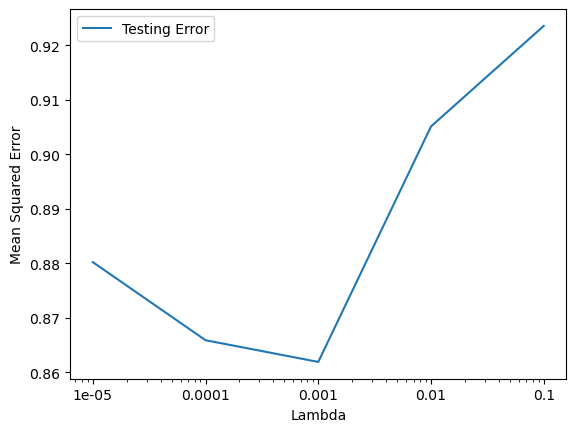

In [24]:
# plot logarithmic graph of regularization parameters vs testing error (with cross validation) for red wine
# also retrieve the best model for red wine
best_red = plotCrossValidationLambdas(red, red_quality)

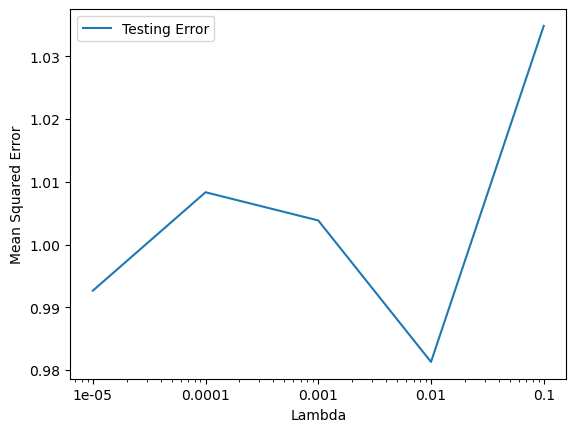

In [25]:
# plot logarithmic graph of regularization parameters vs testing error (with cross validation) for white wine
# also retrieve the best model for white wine
best_white = plotCrossValidationLambdas(white, white_quality)

### In this case, the best lambda varied from red wine to white wine. For red wine, the best lambda appears to be 0.001, while for white wine, it appears to be 0.01.

In [23]:
# identifying potentially unnecessary features
print(best_red.layer.weight.data)
print(best_white.layer.weight.data)
print(red.columns)

tensor([[ 0.0317, -0.1984, -0.0452,  0.0255, -0.0951,  0.0476, -0.1137, -0.0184,
         -0.0646,  0.1593,  0.2947]])
tensor([[-4.8628e-03, -1.9499e-01,  3.4902e-04,  2.4006e-01, -9.4876e-03,
          7.0137e-02, -2.0405e-02, -1.9567e-01,  5.2069e-02,  6.0365e-02,
          3.5398e-01]])
Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')


### For red wine, it appears that all features have a somewhat substantial impact on the quality (the weights are all fairly close in magnitude). However, for white wine, certain features have very low weights, meaning the model determined that they had little to no impact on predicting quality (`fixed acidity`: `-0.0048628`, `citric acid`: `0.0003902`). These features could feasibly be removed.